**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/RLO.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High  Low  Close  Volume  Earnings Yield (EY)  \
0 1999-01-01   820   820  790    820       0                 12.9   
1 1999-01-04   810   810  799    800   71078                 13.2   
2 1999-01-05   800   805  800    800  192045                 13.2   
3 1999-01-06   800   810  800    805  133226                 13.1   
4 1999-01-07   805   815  795    800  119676                 13.2   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  5.2         7.751938      0           0   
1                  5.4         7.575758      0           0   
2                  5.4         7.575758      0           0   
3                  5.3         7.633588      0           0   
4                  5.4         7.575758      0           0   

   Total Return Index (TRI)  
0                596.493392  
1                581.944773  
2                581.944773  
3                585.581928  
4                581.944773

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11 -0.041673  0.041673 -0.010152  0.005115  0.015424  0.041673   
2000-05-12 -0.085158  0.041673  0.000000 -0.010152  0.005115  0.015424   
2000-05-15 -0.106483  0.025577  0.010152  0.010152  0.000000  0.015267   
2000-05-16 -0.153646  0.015267  0.000000  0.010152  0.010152  0.000000   
2000-05-17 -0.157629 -0.030772 -0.030772 -0.030772 -0.020619 -0.020619   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11  0.029212  0.033370  0.029771   0.032176  ...      0.041243   
2000-05-12  0.035407  0.036138  0.029542   0.033902  ...      0.041673   
2000-05-15  0.033134  0.032617  0.027703   0.032389  ...      0.031091   
2000-05-16  0.033087  0.026834  0.026055   0.029276  ...      0.025577   
2000-05-17  0.018684  0.007632  0.020850   0.018358  ...     -0.005141   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11     0.036558      0.041243           0.041243          0.051825   
2000-05-12     0.021053      0.031091           0.041673          0.041673   
2000-05-15     0.031091      0.025577           0.041243          0.041243   
2000-05-16     0.015424      0.025318           0.035627          0.035627   
2000-05-17    -0.015504     -0.030459          -0.005141         -0.005141   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11            0.051825            0.031091           0.041673   
2000-05-12            0.041673            0.041673           0.041673   
2000-05-15            0.025577            0.041243           0.041243   
2000-05-16            0.025318            0.025577           0.025577   
2000-05-17           -0.020409           -0.015504          -0.015504   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11            0.031091          0.051825  
2000-05-12            0.031091          0.041673  
2000-05-15            0.025577          0.031091  
2000-05-16            0.015267          0.025577  
2000-05-17           -0.040822         -0.005141  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.002576050711952346
  dropout = 0.18008333534734158
  units = 217
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 33
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0011766040506041406
RMSE = 0.034301662504959446
MAE = 0.026426235890792044
R-Squared = -0.004699664077757015

Results on Validation set: 
MSE = 0.0011881420167336495
RMSE = 0.03446943597933754
MAE = 0.025037895900913397
R-Squared = -0.016481691158426015

Results on Testing set: 
MSE = 0.0007503742114390918
RMSE = 0.02739295915813207
MAE = 0.021370338280698925
R-Squared = -0.33342524234114235



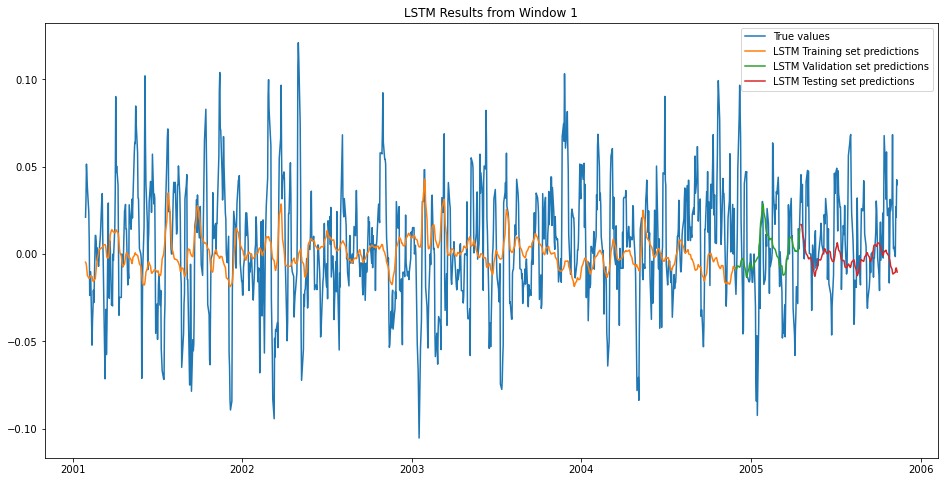

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0009151524512869434
RMSE = 0.030251486761594767
MAE = 0.022950441979971016
R-Squared = 0.17983330725520263

Results on Validation set: 
MSE = 0.0006280069216856371
RMSE = 0.02506006627456594
MAE = 0.019693714975361598
R-Squared = -0.03980888062893517

Results on Testing set: 
MSE = 0.0019505291857632922
RMSE = 0.04416479577404714
MAE = 0.03591760004219361
R-Squared = -0.3236559131660264



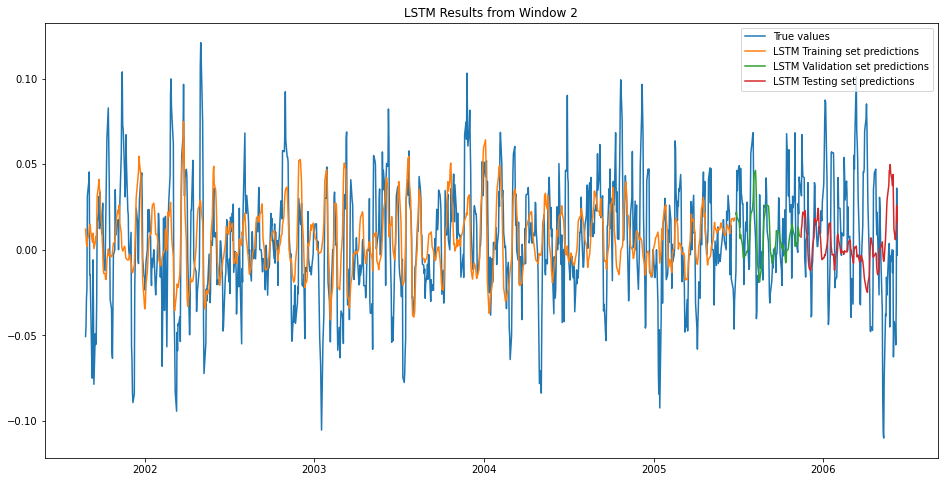

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0009557767623181939
RMSE = 0.03091563944540358
MAE = 0.02401748406175338
R-Squared = 0.027025114254440652

Results on Validation set: 
MSE = 0.00161837088962947
RMSE = 0.04022898071825173
MAE = 0.03189566798139841
R-Squared = 0.023129585768658645

Results on Testing set: 
MSE = 0.0010014045829290664
RMSE = 0.03164497721486091
MAE = 0.024541400922528666
R-Squared = 0.02614182884860028



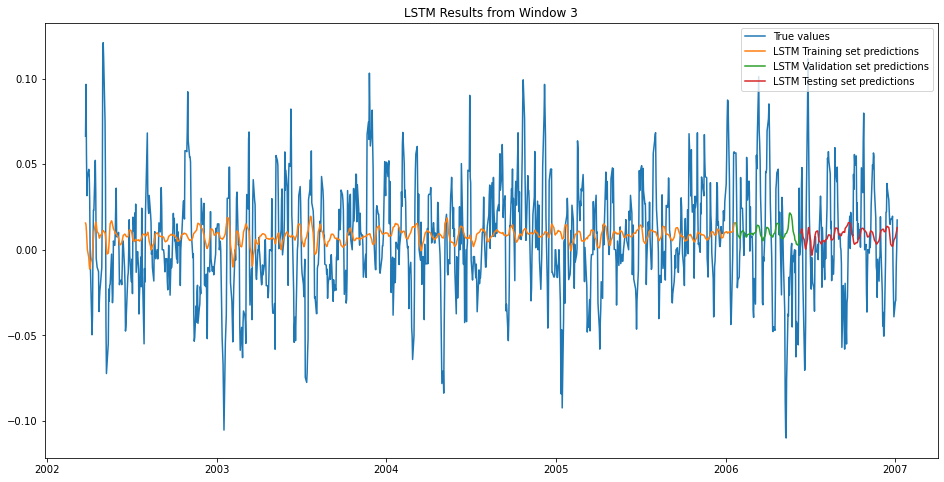

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.001027246661796124
RMSE = 0.03205068894417285
MAE = 0.024837754252111127
R-Squared = 0.038878364245225505

Results on Validation set: 
MSE = 0.0009660027429947278
RMSE = 0.031080584663013142
MAE = 0.024391984547372944
R-Squared = -0.07249158978782955

Results on Testing set: 
MSE = 0.0009218329021962113
RMSE = 0.030361701240151404
MAE = 0.024458137531107156
R-Squared = -0.18911044593863569



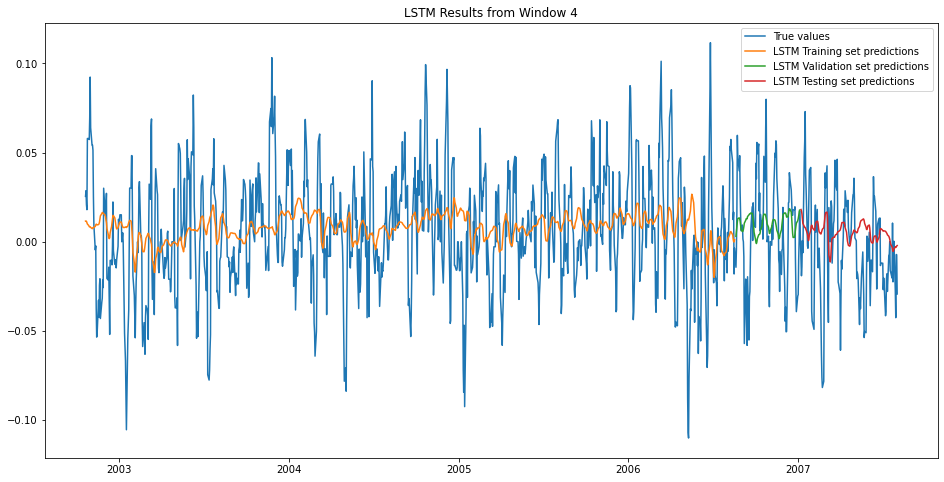

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0009788421256926568
RMSE = 0.03128645275023451
MAE = 0.024412368497213614
R-Squared = 0.047206055631519805

Results on Validation set: 
MSE = 0.0008179266795578228
RMSE = 0.02859941746885455
MAE = 0.023597344549765194
R-Squared = -0.5369463241088313

Results on Testing set: 
MSE = 0.001975793497308721
RMSE = 0.04444989873226621
MAE = 0.03471261700900872
R-Squared = -0.16435039750664293



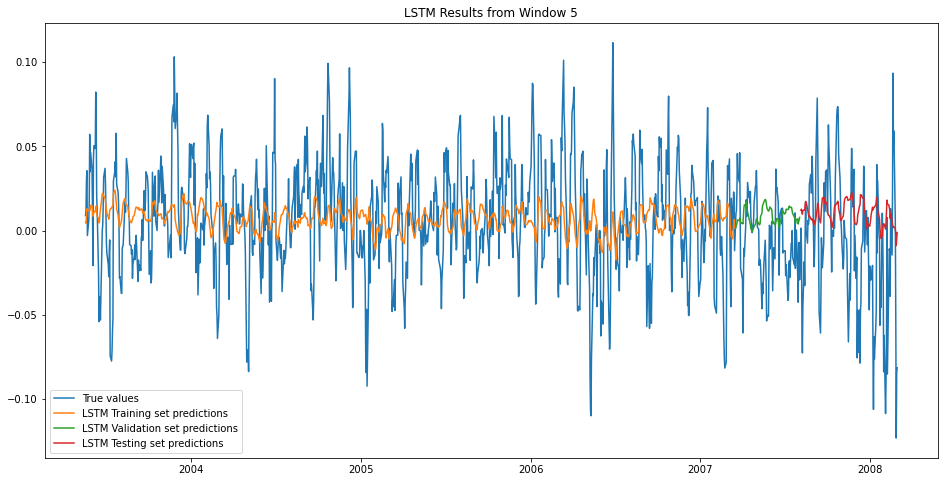

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.000978214575446148
RMSE = 0.03127642203715361
MAE = 0.024483847093790468
R-Squared = 0.010263268028047445

Results on Validation set: 
MSE = 0.002024534864240271
RMSE = 0.044994831528079655
MAE = 0.0362779445298095
R-Squared = -0.056474583927200284

Results on Testing set: 
MSE = 0.0019256006747931532
RMSE = 0.04388166672761135
MAE = 0.03515966145675955
R-Squared = -0.09335148276508387



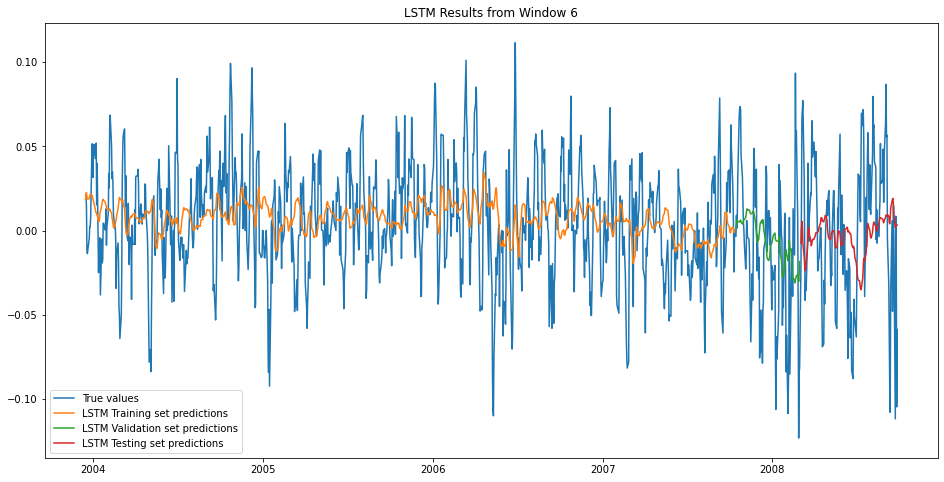

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0008877773785021301
RMSE = 0.029795593273202838
MAE = 0.022883134430502255
R-Squared = 0.22893691036886765

Results on Validation set: 
MSE = 0.0017358965948850624
RMSE = 0.04166409239243143
MAE = 0.0330526017943325
R-Squared = 0.13513797039696995

Results on Testing set: 
MSE = 0.0065253242584597205
RMSE = 0.08077947919156028
MAE = 0.06460165177491889
R-Squared = -0.0694753769190557



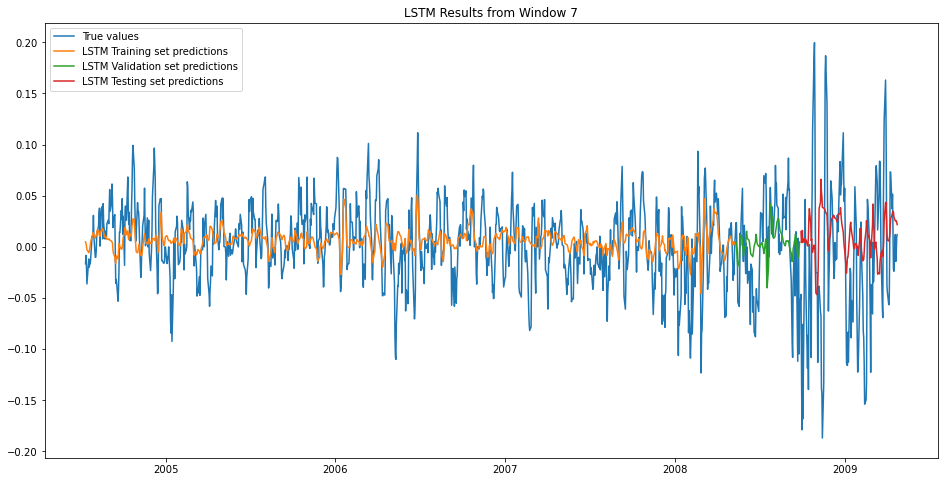

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0014185720343417045
RMSE = 0.0376639354600884
MAE = 0.027566636507427758
R-Squared = 0.15120293853832656

Results on Validation set: 
MSE = 0.003254242371533323
RMSE = 0.05704596718027772
MAE = 0.04655606954576373
R-Squared = 0.2621333505386556

Results on Testing set: 
MSE = 0.002498969367666633
RMSE = 0.04998969261424432
MAE = 0.039264879029681364
R-Squared = -0.34648779690730813



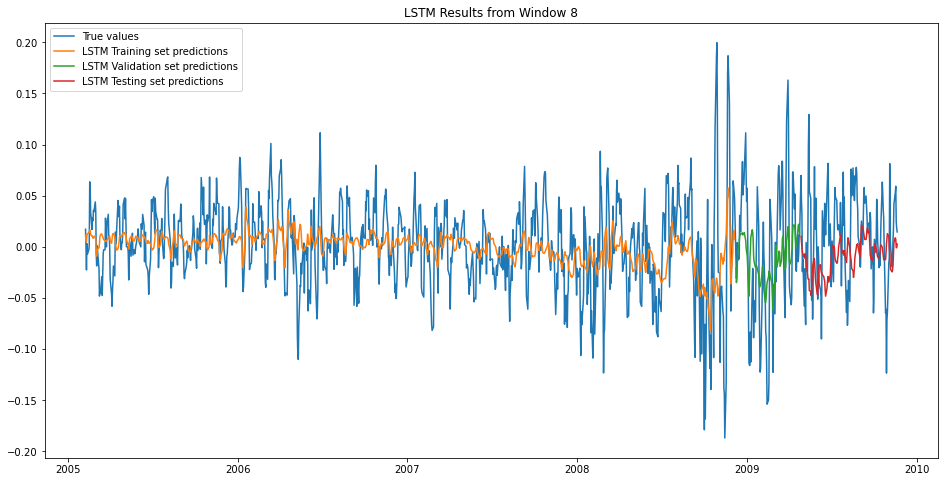

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0007399477110139323
RMSE = 0.027201979909814145
MAE = 0.02010641352667066
R-Squared = 0.6514027331309766

Results on Validation set: 
MSE = 0.001466302157257119
RMSE = 0.038292325043761954
MAE = 0.030394014647442003
R-Squared = 0.09225364993699858

Results on Testing set: 
MSE = 0.0005682716700390134
RMSE = 0.02383844940508953
MAE = 0.019379870496322324
R-Squared = -0.37865291063715323



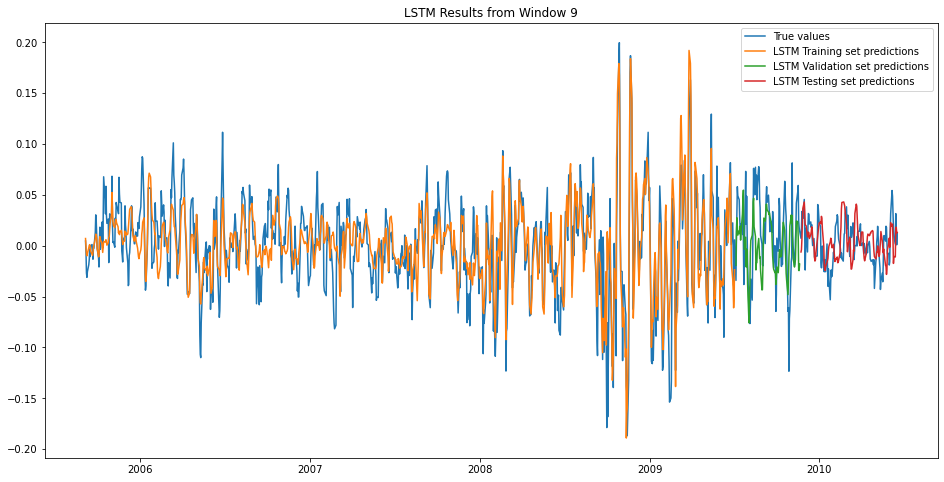

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0018866384372973645
RMSE = 0.04343545138820782
MAE = 0.032635440287204665
R-Squared = 0.12558902876278055

Results on Validation set: 
MSE = 0.0002697810977562702
RMSE = 0.016425014391356563
MAE = 0.013086923018362309
R-Squared = 0.158508413628054

Results on Testing set: 
MSE = 0.0004093142289605872
RMSE = 0.020231515735618703
MAE = 0.01676857607836657
R-Squared = -0.07408869578930077



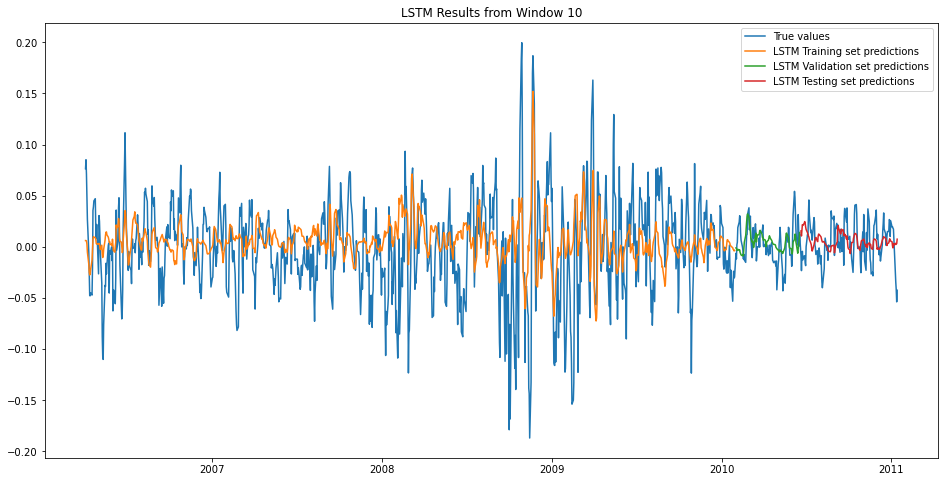

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0014738836956522802
RMSE = 0.038391192943854714
MAE = 0.028413320288908587
R-Squared = 0.25663338869259356

Results on Validation set: 
MSE = 0.00033470860252563287
RMSE = 0.018295043113522112
MAE = 0.014851805050004498
R-Squared = 0.15177136517471024

Results on Testing set: 
MSE = 0.0007301012375385478
RMSE = 0.027020385591966442
MAE = 0.021751132513843457
R-Squared = -0.12613059748629896



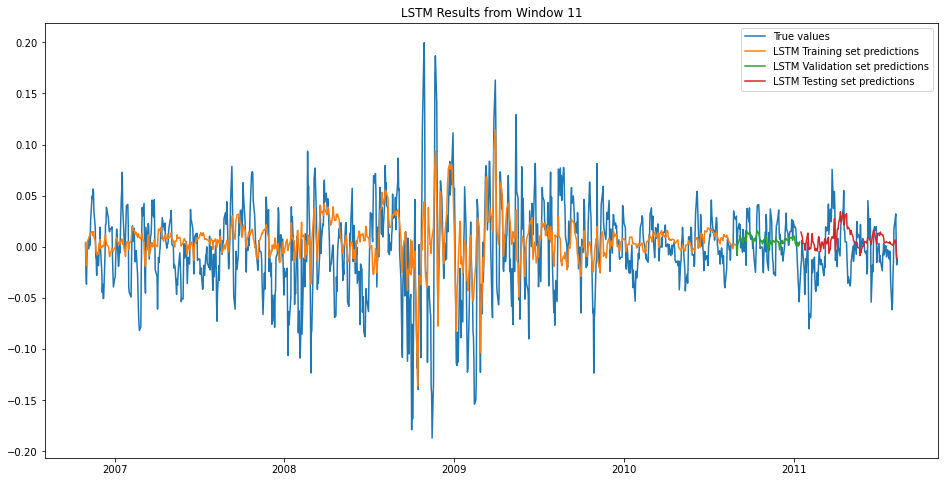

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0014082519626395981
RMSE = 0.037526683341851545
MAE = 0.027270921515870745
R-Squared = 0.27580231113510556

Results on Validation set: 
MSE = 0.00034082298154936415
RMSE = 0.01846139164714741
MAE = 0.01437555252151445
R-Squared = 0.2872220576904154

Results on Testing set: 
MSE = 0.0006332364217313009
RMSE = 0.02516418927228336
MAE = 0.020271051501743808
R-Squared = -0.06560056491558575



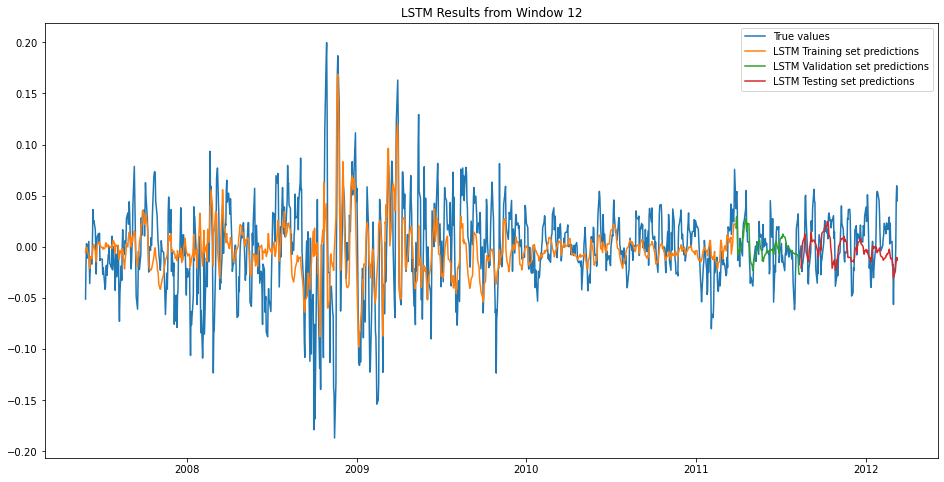

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.001666071844081342
RMSE = 0.04081754333716499
MAE = 0.02927169486663509
R-Squared = 0.11288338804215581

Results on Validation set: 
MSE = 0.0005209965875639243
RMSE = 0.02282534967013483
MAE = 0.018603990857092623
R-Squared = 0.14152994132132768

Results on Testing set: 
MSE = 0.0008316183405330636
RMSE = 0.028837793614163058
MAE = 0.022692164855721297
R-Squared = -0.0271941370262756



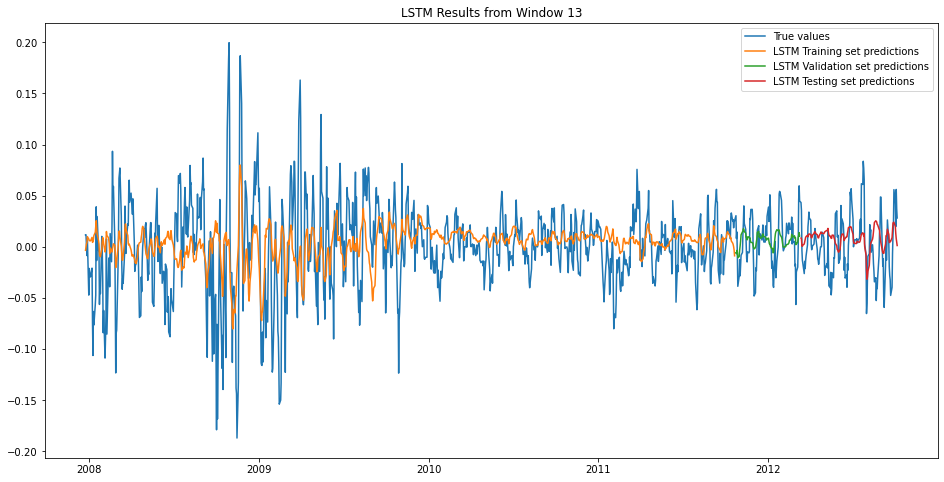

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0015548207201326791
RMSE = 0.039431215047633
MAE = 0.02720997175439525
R-Squared = 0.06971747690976926

Results on Validation set: 
MSE = 0.0008526242394209507
RMSE = 0.02919973012582395
MAE = 0.022725625289561246
R-Squared = 0.13315055784347085

Results on Testing set: 
MSE = 0.001286990677163584
RMSE = 0.035874652293277826
MAE = 0.026745752295010743
R-Squared = 0.009463042692984147



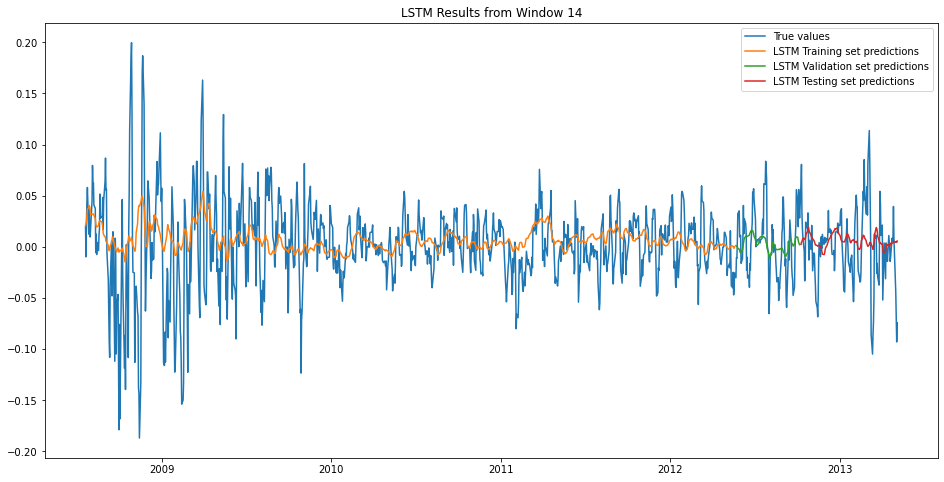

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0008710302589698002
RMSE = 0.029513221765334264
MAE = 0.022620046274257923
R-Squared = 0.1029011954808926

Results on Validation set: 
MSE = 0.0014359399315672274
RMSE = 0.0378937980620474
MAE = 0.02861186382615089
R-Squared = 0.09284808256588295

Results on Testing set: 
MSE = 0.0015536955701493077
RMSE = 0.03941694521584984
MAE = 0.029902649343093658
R-Squared = -0.04936553344161365



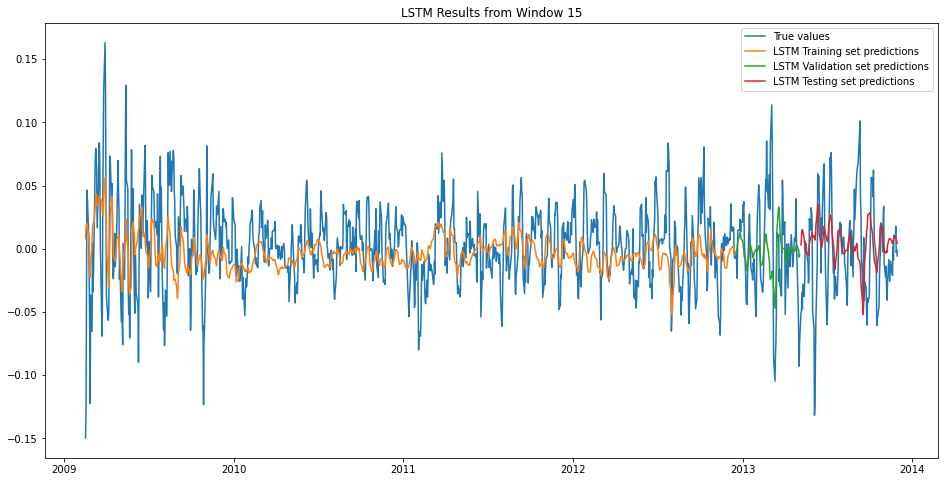

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.000761936964016521
RMSE = 0.027603205683697698
MAE = 0.021347093072379354
R-Squared = 0.07811790379976757

Results on Validation set: 
MSE = 0.0012010521032988456
RMSE = 0.03465619862735735
MAE = 0.02620986948734264
R-Squared = -0.10412364441562061

Results on Testing set: 
MSE = 0.0011301915235806968
RMSE = 0.033618321248698554
MAE = 0.025587353508068292
R-Squared = -0.2122917118332297



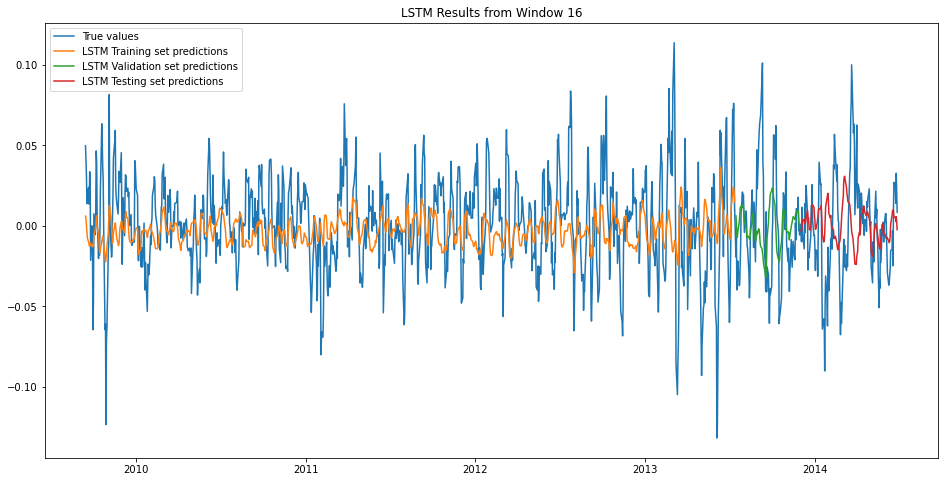

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0007691798722159073
RMSE = 0.02773409223709886
MAE = 0.02104135038396389
R-Squared = 0.10666278331944301

Results on Validation set: 
MSE = 0.0010874649016562666
RMSE = 0.03297673273167411
MAE = 0.02620192079625279
R-Squared = -0.1350683502309009

Results on Testing set: 
MSE = 0.0009778317649679828
RMSE = 0.031270301644979105
MAE = 0.025895252826443785
R-Squared = -0.0036696344207205467



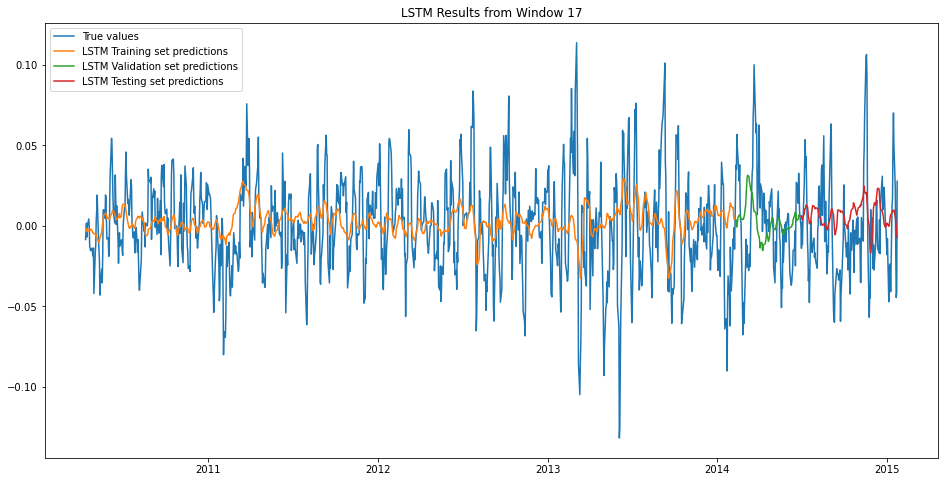

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0008311907370051288
RMSE = 0.02883037871768473
MAE = 0.022024590059620777
R-Squared = 0.1125718283001147

Results on Validation set: 
MSE = 0.0009832776218350872
RMSE = 0.03135725788131174
MAE = 0.024501947371576946
R-Squared = 0.08265230677352386

Results on Testing set: 
MSE = 0.000952615892983046
RMSE = 0.030864476230499132
MAE = 0.024000024437296905
R-Squared = 0.08139705703883948



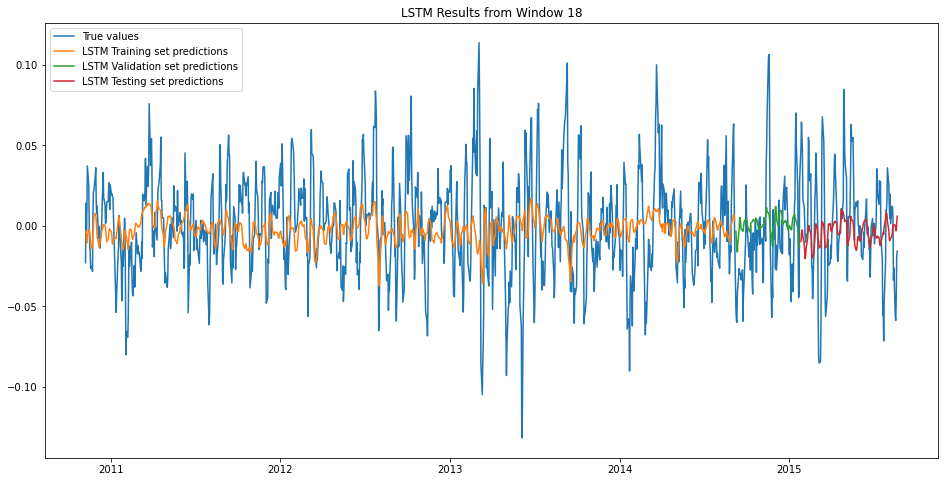

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0009715174266225683
RMSE = 0.031169174301263872
MAE = 0.023791641720868027
R-Squared = 0.05122182742247161

Results on Validation set: 
MSE = 0.0006953390346977604
RMSE = 0.02636928202848459
MAE = 0.01990128823760522
R-Squared = 0.09847276474572753

Results on Testing set: 
MSE = 0.0011795857591309444
RMSE = 0.03434509803641481
MAE = 0.02741986486340083
R-Squared = -0.06981536908504427



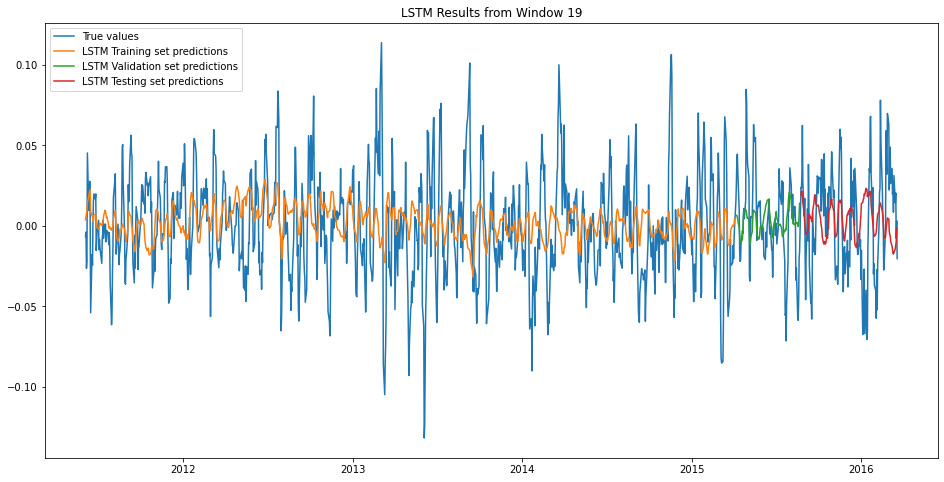

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0009963062595060048
RMSE = 0.0315643194050815
MAE = 0.024128904199620813
R-Squared = 0.06509794825313153

Results on Validation set: 
MSE = 0.0012511023172824367
RMSE = 0.035370924744519146
MAE = 0.02906762405308182
R-Squared = 0.008911143671081256

Results on Testing set: 
MSE = 0.0005616719534350683
RMSE = 0.023699619267723866
MAE = 0.017580435545823607
R-Squared = 0.017537827304682674



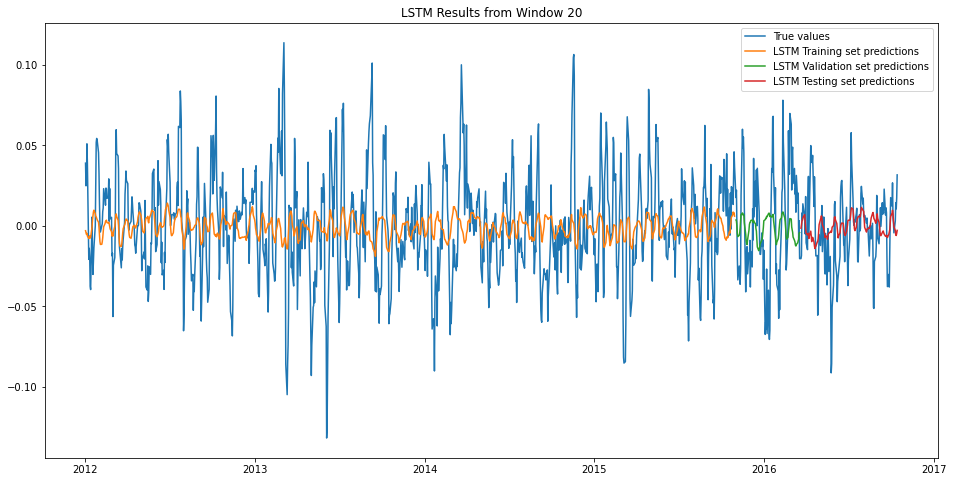

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0008482914172847811
RMSE = 0.02912544278263905
MAE = 0.02189060283598078
R-Squared = 0.24493101336752188

Results on Validation set: 
MSE = 0.0003326830222994828
RMSE = 0.018239600387603968
MAE = 0.01443226981623403
R-Squared = 0.17277149706487493

Results on Testing set: 
MSE = 0.0009058919468078578
RMSE = 0.03009803891963491
MAE = 0.023969342363250677
R-Squared = -0.44094925554948183



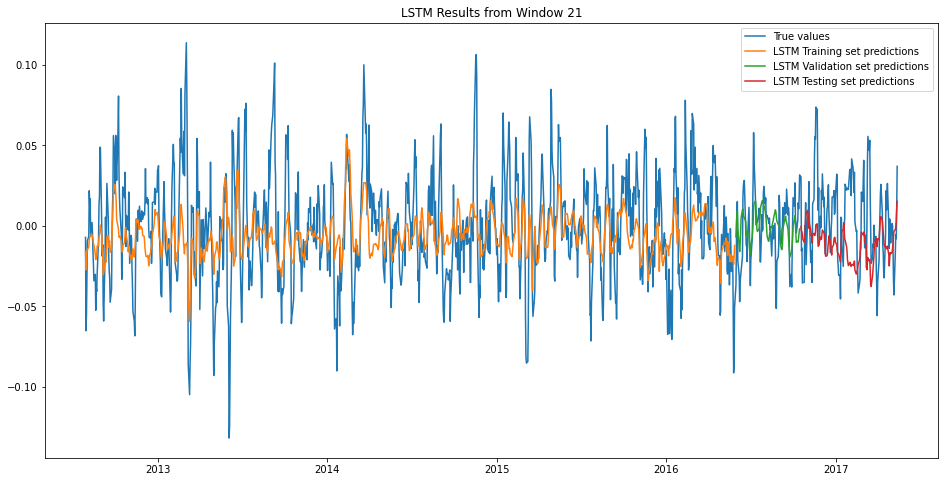

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.001023901307110012
RMSE = 0.0319984578864359
MAE = 0.024557057824815147
R-Squared = 0.03727249968491553

Results on Validation set: 
MSE = 0.0006940088229587457
RMSE = 0.02634404720157375
MAE = 0.02178700178718261
R-Squared = -0.14264737070132583

Results on Testing set: 
MSE = 0.0008855650752393238
RMSE = 0.029758445443929422
MAE = 0.025153426734669526
R-Squared = -0.23794826953749326



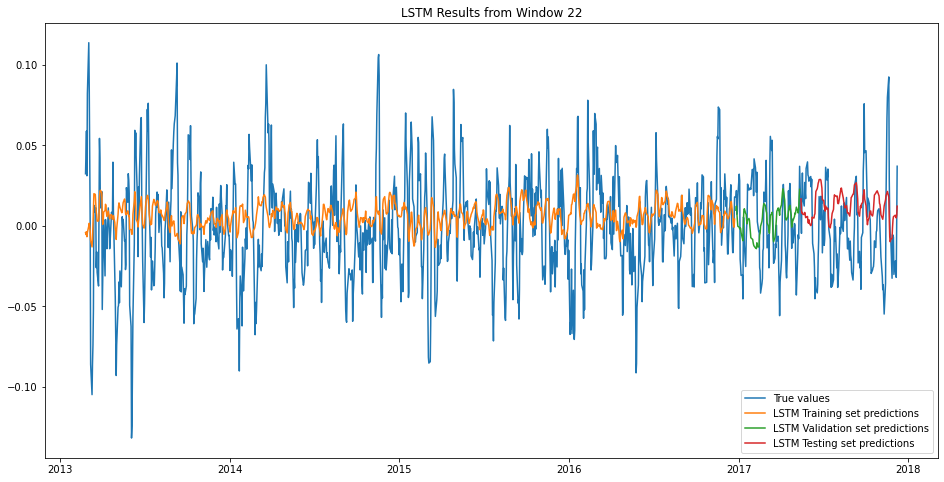

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0008517276106786414
RMSE = 0.02918437271346844
MAE = 0.022786723034128344
R-Squared = 0.024652400212128667

Results on Validation set: 
MSE = 0.0006616519719827142
RMSE = 0.02572259652489838
MAE = 0.01948513569606195
R-Squared = 0.10522256147632525

Results on Testing set: 
MSE = 0.0008850072058012696
RMSE = 0.029749070671220464
MAE = 0.023263641399539726
R-Squared = -0.3675644119927235



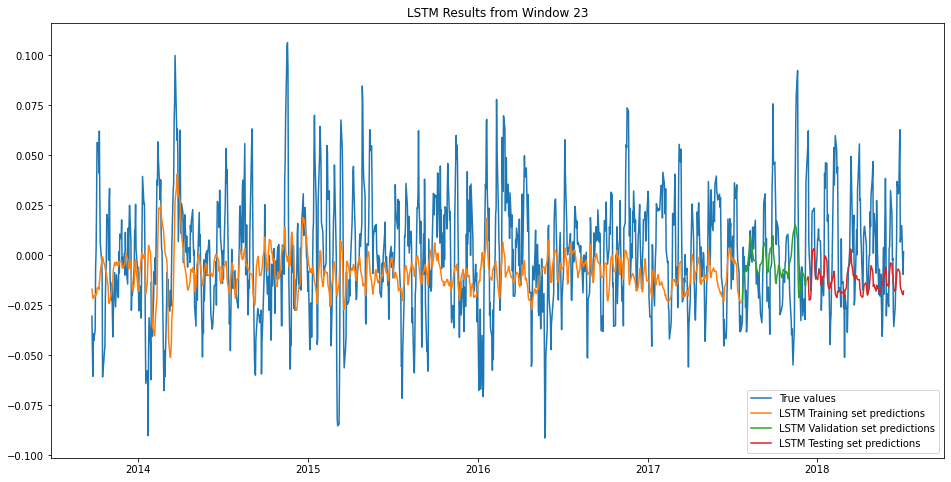

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0007285579363257245
RMSE = 0.026991812394237712
MAE = 0.02109554622140994
R-Squared = 0.11772792228618656

Results on Validation set: 
MSE = 0.00045153869520912326
RMSE = 0.0212494398798915
MAE = 0.01681411403380351
R-Squared = 0.19603763386563955

Results on Testing set: 
MSE = 0.0013172174564034563
RMSE = 0.03629349055138478
MAE = 0.02761011597400216
R-Squared = 0.0219134490459878



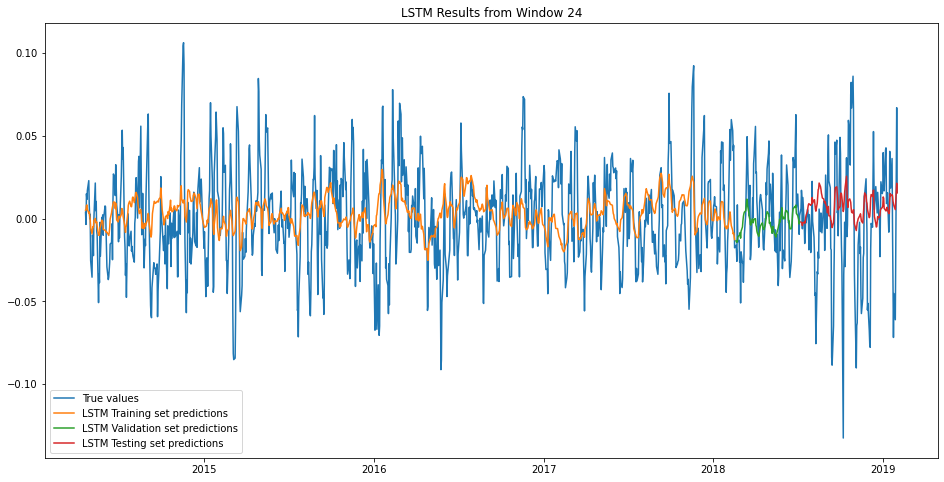

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4931

Results on Training set: 
MSE = 0.0006735974180816855
RMSE = 0.02595375537531487
MAE = 0.019927168347063675
R-Squared = 0.1773540633577726

Results on Validation set: 
MSE = 0.0013945188726440366
RMSE = 0.03734325739198492
MAE = 0.02846437255909741
R-Squared = 0.1552007663961038

Results on Testing set: 
MSE = 0.0016076309085652088
RMSE = 0.04009527289550738
MAE = 0.032050444666276705
R-Squared = -0.08962966164378039



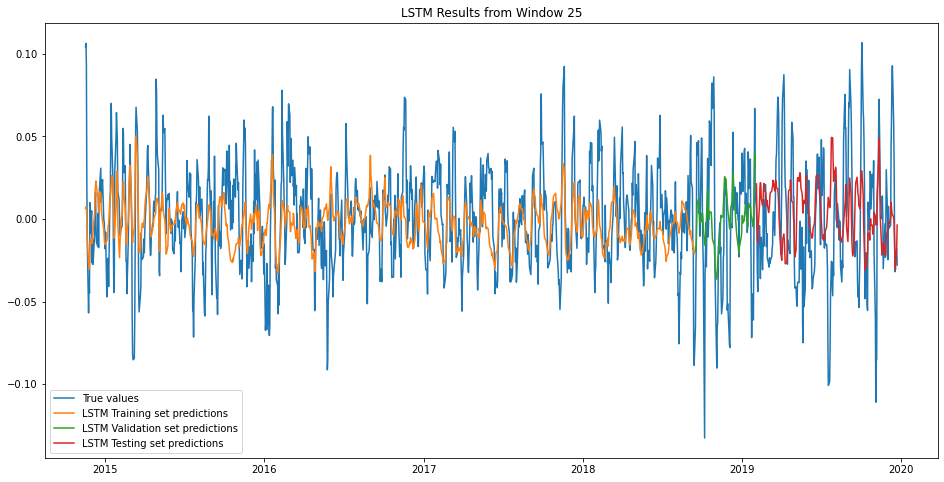

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 187
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.004836927180682221
  dropout =  0.18507824608274567
  units = 227

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 20
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0007420532305989708
RMSE = 0.027240654004611762
MAE = 0.020455019912475614
R-Squared = 0.3837313920975598

Results on Validation set: 
MSE = 0.0011202757660550662
RMSE = 0.03347052085126651
MAE = 0.025790111193120212
R-Squared = 0.00979319459198158

Results on Testing set: 
MSE = 0.0011550093093105726
RMSE = 0.0339854278965349
MAE = 0.027031226525934322
R-Squared = -0.9566439135019211



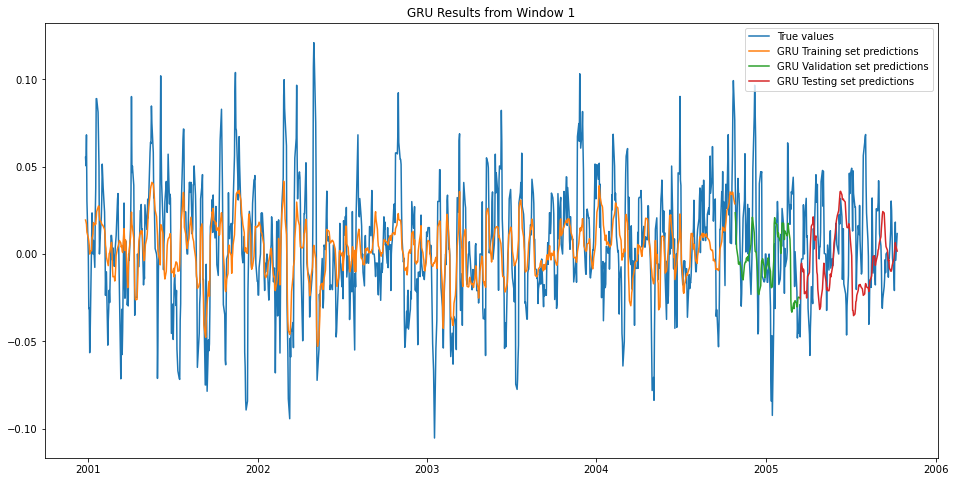

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0008251604750779924
RMSE = 0.02872560660939978
MAE = 0.02151941487134211
R-Squared = 0.27453891073668335

Results on Validation set: 
MSE = 0.00046962434690055844
RMSE = 0.021670817864136056
MAE = 0.017094831210917247
R-Squared = 0.16214381792872012

Results on Testing set: 
MSE = 0.0019816665399583276
RMSE = 0.04451591333397898
MAE = 0.03711199444086484
R-Squared = -0.9585754411558915



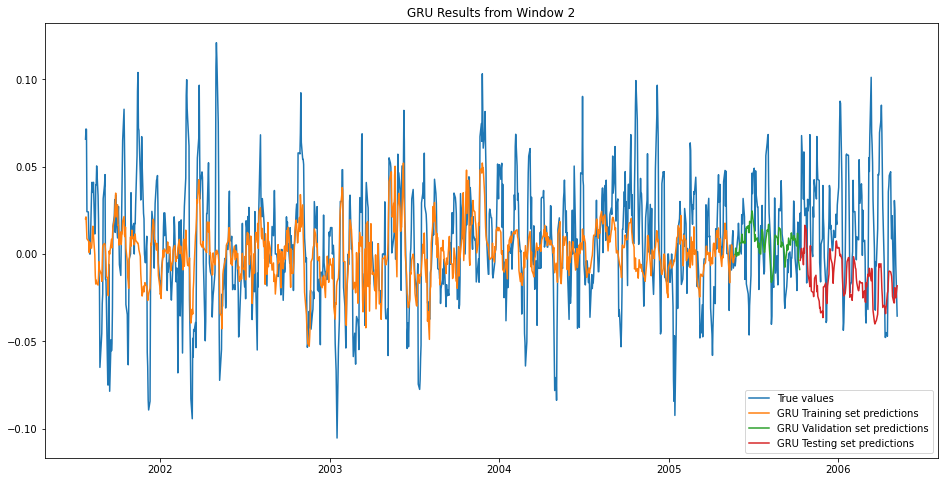

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0009655437371844043
RMSE = 0.031073199661193634
MAE = 0.024008559088502347
R-Squared = 0.05694018038206494

Results on Validation set: 
MSE = 0.0011405084610526127
RMSE = 0.03377141485121126
MAE = 0.027049055455739976
R-Squared = 0.05766909898125405

Results on Testing set: 
MSE = 0.0015681841299935982
RMSE = 0.03960030467046432
MAE = 0.030657579689240932
R-Squared = -0.1874403848085291



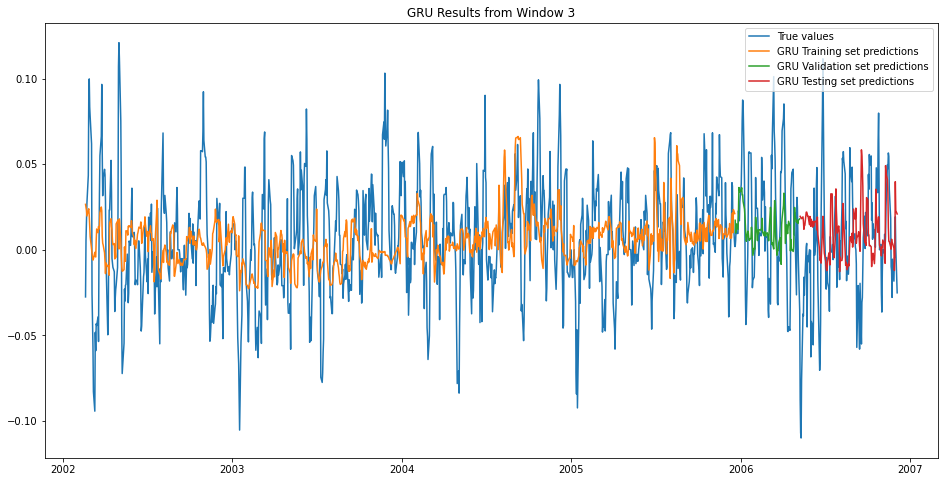

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.001056208674988537
RMSE = 0.03249936422437425
MAE = 0.025130932653947873
R-Squared = 0.003244907054757995

Results on Validation set: 
MSE = 0.0008821060331582147
RMSE = 0.02970026991726194
MAE = 0.023301733288192506
R-Squared = -0.07862417993939785

Results on Testing set: 
MSE = 0.0012443900786115048
RMSE = 0.03527591357585945
MAE = 0.027903233066757807
R-Squared = -0.47534000689219624



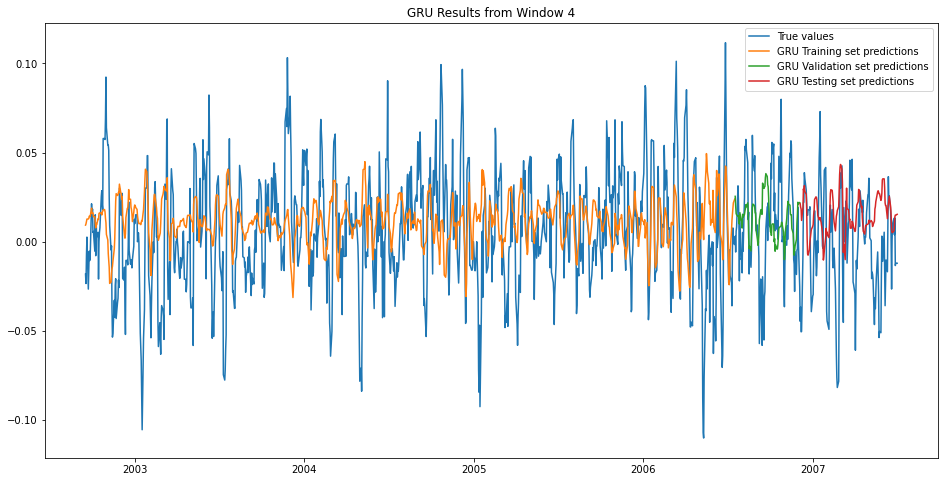

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0009507074957204424
RMSE = 0.030833544974920454
MAE = 0.024080302662289655
R-Squared = 0.0574179925436874

Results on Validation set: 
MSE = 0.000782098228046146
RMSE = 0.027966019166948772
MAE = 0.021273967558133176
R-Squared = -0.0033340393125962375

Results on Testing set: 
MSE = 0.001571478637567532
RMSE = 0.03964187984401764
MAE = 0.03149579646970514
R-Squared = -0.32907939453916346



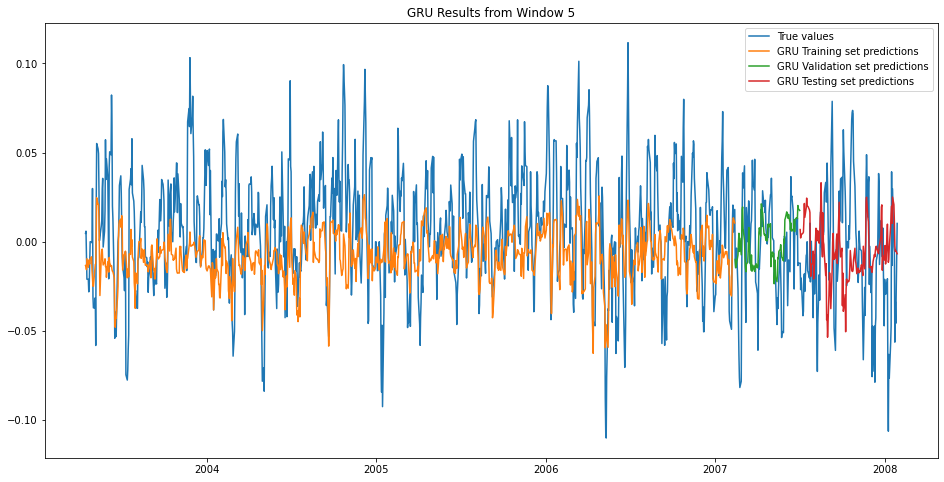

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0008785710427644183
RMSE = 0.029640699093719403
MAE = 0.023687938418364113
R-Squared = 0.13225264298859107

Results on Validation set: 
MSE = 0.0013888099232823097
RMSE = 0.03726674017515229
MAE = 0.029756232184492654
R-Squared = 0.01771665957018498

Results on Testing set: 
MSE = 0.0017724822719665464
RMSE = 0.04210085832814512
MAE = 0.0341090506026852
R-Squared = 0.03953843131737311



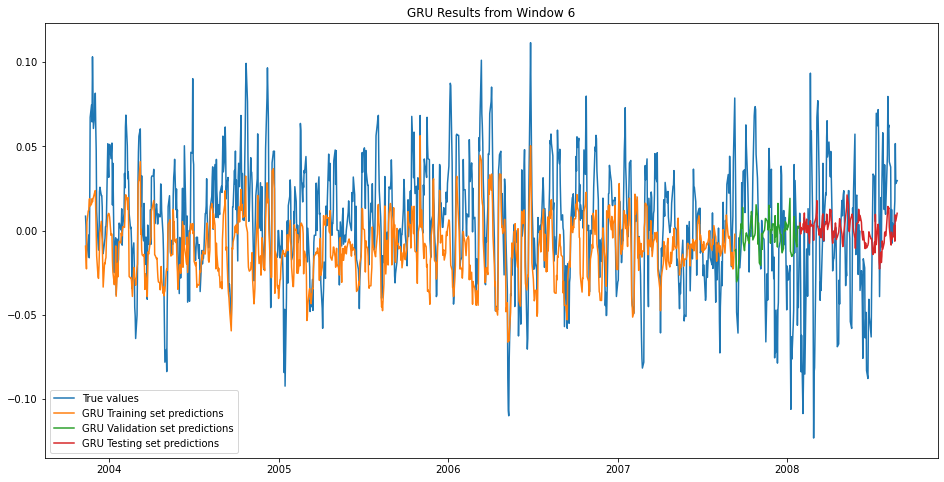

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0011696089784026498
RMSE = 0.034199546464867774
MAE = 0.026388086323709734
R-Squared = -0.017956915244166982

Results on Validation set: 
MSE = 0.001413973734468447
RMSE = 0.03760284210626169
MAE = 0.030539571980327675
R-Squared = -0.004646097903910906

Results on Testing set: 
MSE = 0.006235094112154366
RMSE = 0.07896261211582584
MAE = 0.06360094065323238
R-Squared = -0.0615054001796711



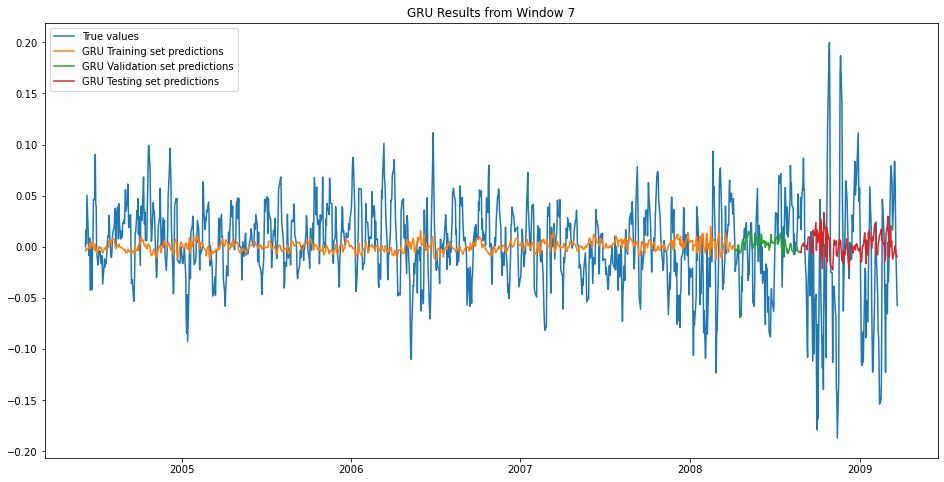

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0011381727473850991
RMSE = 0.033736815904662654
MAE = 0.02494769168491844
R-Squared = 0.22926158772018057

Results on Validation set: 
MSE = 0.005011952034563952
RMSE = 0.0707951413203191
MAE = 0.05686577909163058
R-Squared = 0.09900445038573524

Results on Testing set: 
MSE = 0.0034240901746343797
RMSE = 0.05851572587462604
MAE = 0.05034738031151656
R-Squared = -0.6645586974404896



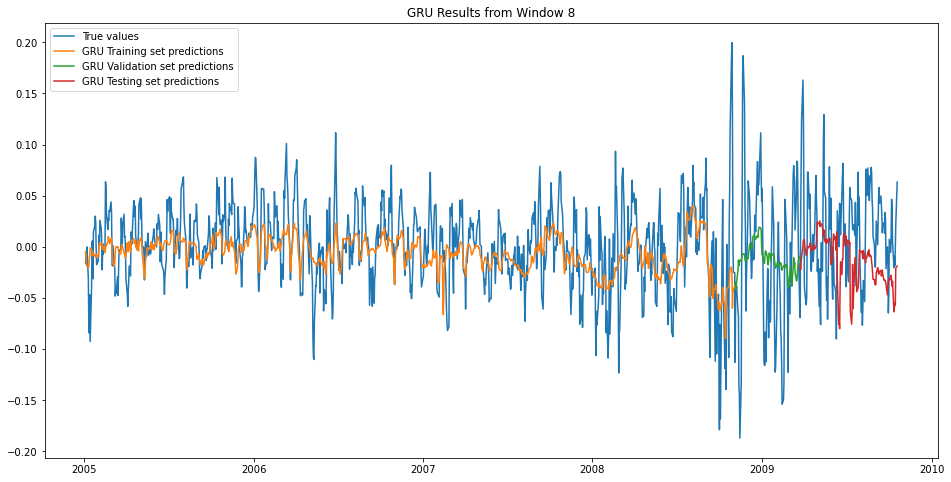

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0011572283588817344
RMSE = 0.03401805930504758
MAE = 0.025251036117992055
R-Squared = 0.44982609915021465

Results on Validation set: 
MSE = 0.0015517205091287694
RMSE = 0.039391883797665346
MAE = 0.030584818381487463
R-Squared = -0.05487987935392269

Results on Testing set: 
MSE = 0.0011322091634401212
RMSE = 0.033648315907933955
MAE = 0.027163008733816198
R-Squared = -0.632268143379578



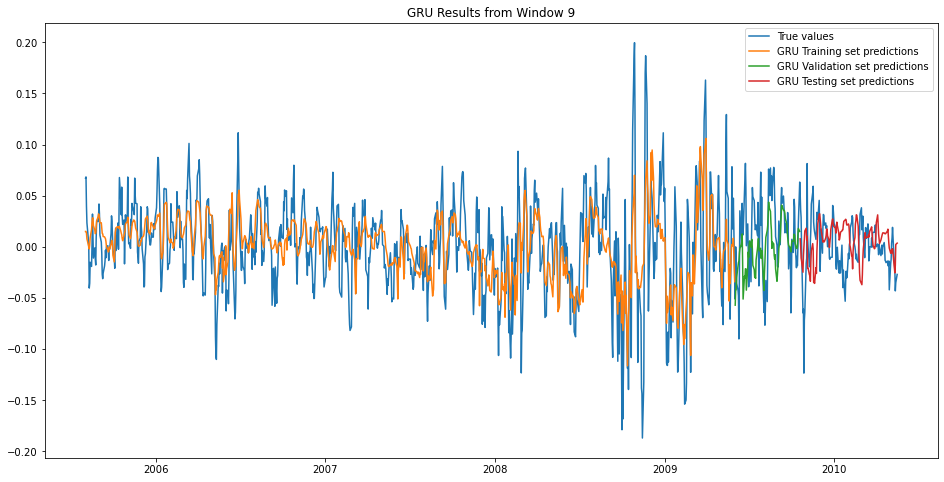

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0021257918206323482
RMSE = 0.0461063099871628
MAE = 0.034835024039577736
R-Squared = 0.02957866618072813

Results on Validation set: 
MSE = 0.000359851723998423
RMSE = 0.018969758142855248
MAE = 0.015225527114584893
R-Squared = 0.05415369660315972

Results on Testing set: 
MSE = 0.00043217596930763066
RMSE = 0.02078884242346434
MAE = 0.016565543956255247
R-Squared = -0.20022355303897976



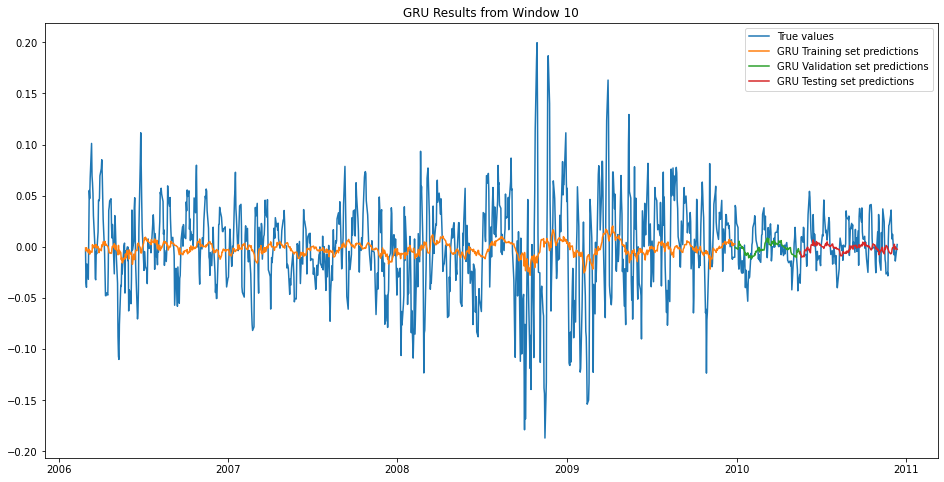

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0020969515008432776
RMSE = 0.04579248301679303
MAE = 0.03369272032911553
R-Squared = -0.045239279945190836

Results on Validation set: 
MSE = 0.00038349148008614284
RMSE = 0.01958293849467293
MAE = 0.015377370179663874
R-Squared = -0.08265621927100852

Results on Testing set: 
MSE = 0.0008382607500921546
RMSE = 0.02895273303320698
MAE = 0.022845532393295665
R-Squared = -0.22999743967532527



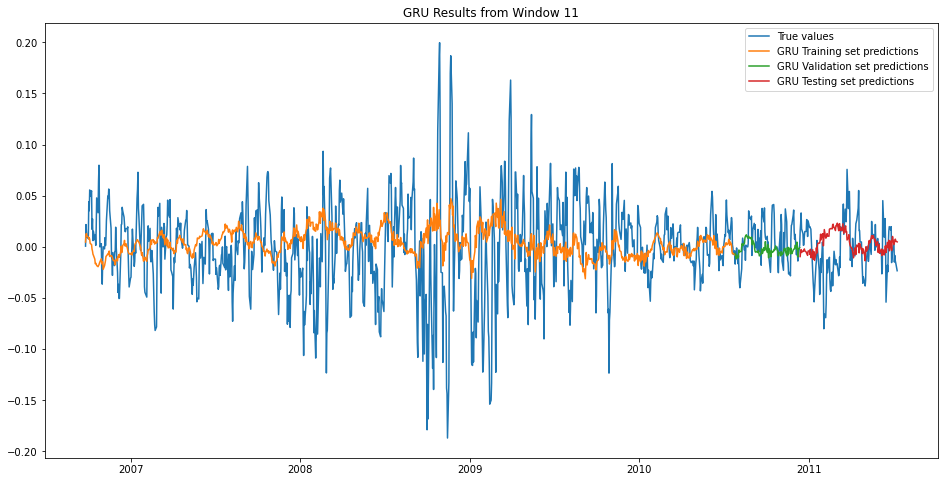

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.001534152287965344
RMSE = 0.039168256126171155
MAE = 0.028949666080877727
R-Squared = 0.20993322678097348

Results on Validation set: 
MSE = 0.0004930900693718574
RMSE = 0.022205631478790632
MAE = 0.01844272368023706
R-Squared = 0.09463910341823667

Results on Testing set: 
MSE = 0.0006280159321832926
RMSE = 0.02506024605193039
MAE = 0.0203613847663889
R-Squared = -0.05541226865904081



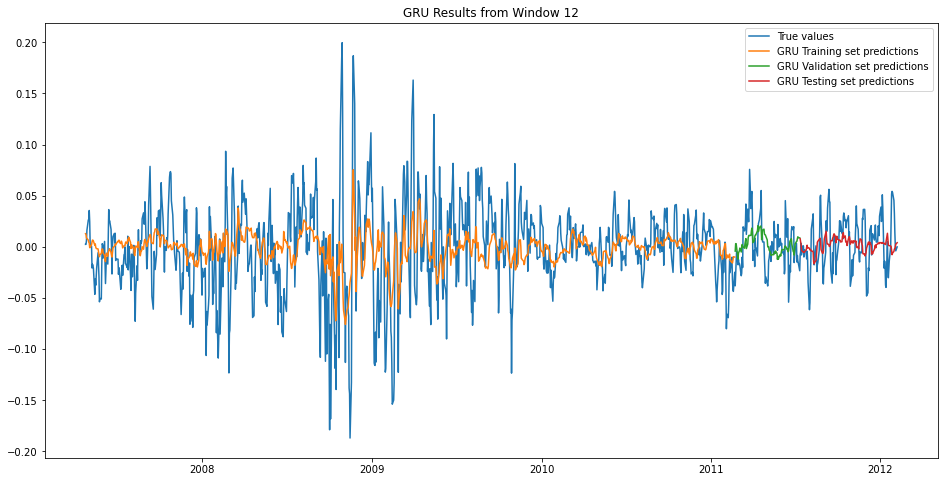

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0017760566511476944
RMSE = 0.042143287142173594
MAE = 0.030669165484443702
R-Squared = 0.06853765177376625

Results on Validation set: 
MSE = 0.0005549324439050582
RMSE = 0.02355700413688163
MAE = 0.01890413457103297
R-Squared = -0.04493570653535728

Results on Testing set: 
MSE = 0.0007547571484653993
RMSE = 0.027472843836512436
MAE = 0.022456471257569017
R-Squared = -0.010540881840164662



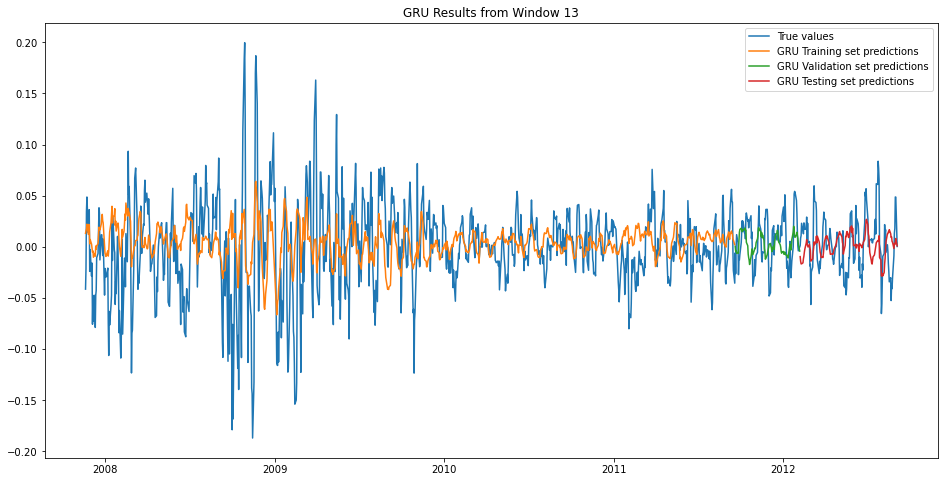

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0015698631868465403
RMSE = 0.039621499048452725
MAE = 0.02788892914683492
R-Squared = 0.08780083082544565

Results on Validation set: 
MSE = 0.0008051806003009841
RMSE = 0.028375704401846735
MAE = 0.02206286995806393
R-Squared = 0.07595700753431445

Results on Testing set: 
MSE = 0.0012085277135791995
RMSE = 0.03476388519108874
MAE = 0.02623885184791829
R-Squared = 0.04476535807254722



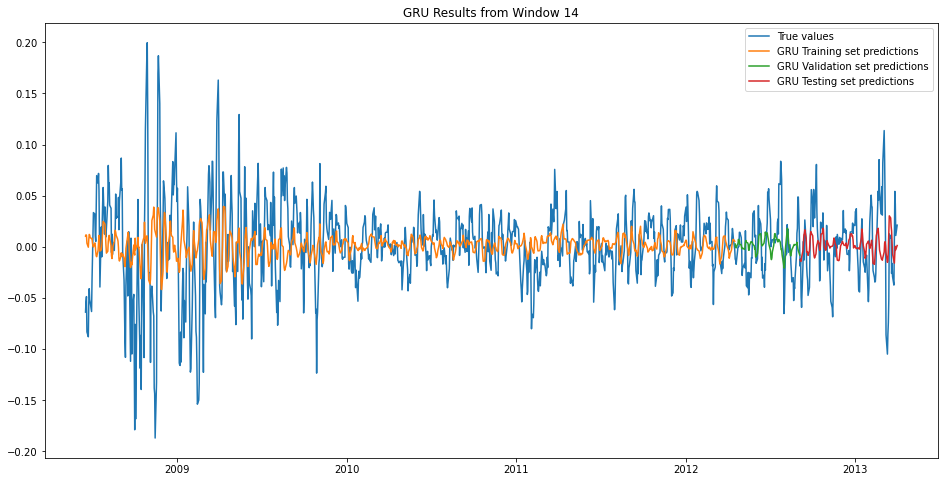

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.00045749285701201993
RMSE = 0.021389082659432124
MAE = 0.016223456855848247
R-Squared = 0.579251804035691

Results on Validation set: 
MSE = 0.001035308533956031
RMSE = 0.032176210683609575
MAE = 0.023228031031715703
R-Squared = 0.2535961539030218

Results on Testing set: 
MSE = 0.0025275957991682594
RMSE = 0.05027520063777229
MAE = 0.04021581045664045
R-Squared = -0.5712705601542425



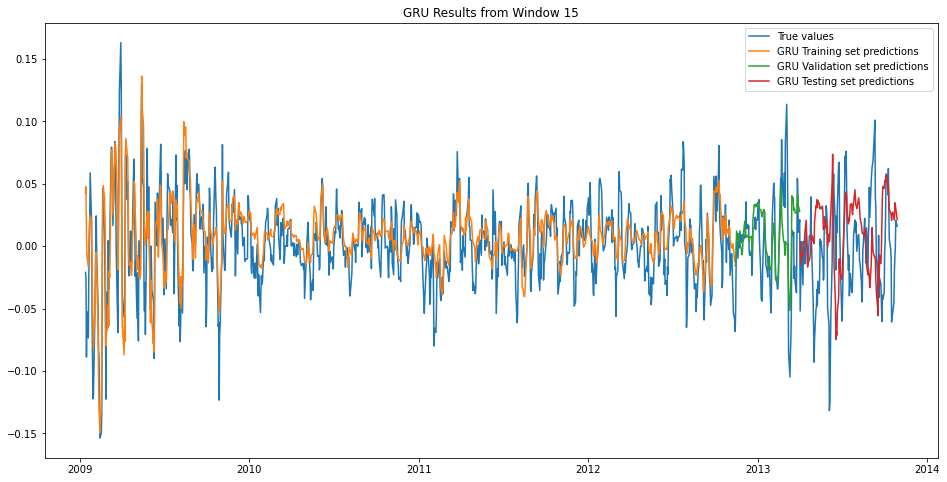

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0009656998572673798
RMSE = 0.03107571169365844
MAE = 0.02390794917439015
R-Squared = -0.16176796293850315

Results on Validation set: 
MSE = 0.00121443509045754
RMSE = 0.03484874589504678
MAE = 0.02650336614587805
R-Squared = 0.1531473758838885

Results on Testing set: 
MSE = 0.0010229329396860428
RMSE = 0.031983322836848
MAE = 0.026243856209662932
R-Squared = -0.10845000750362299



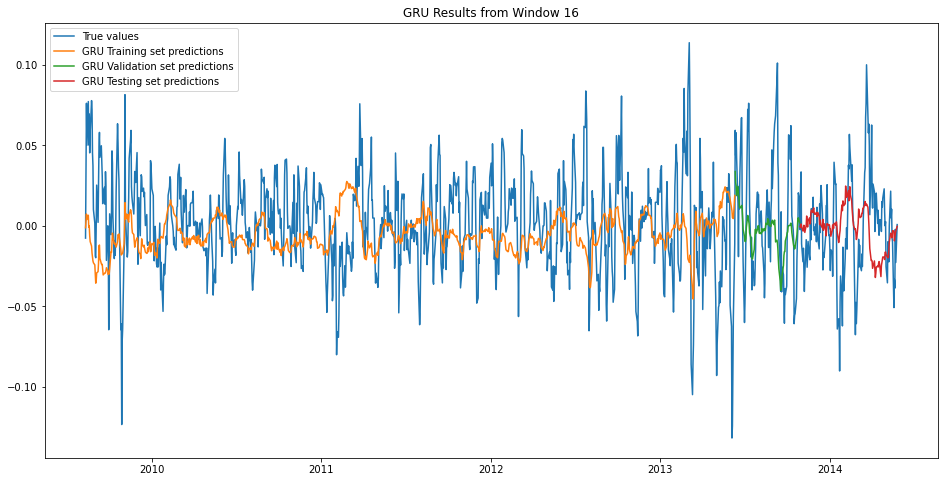

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0007552984465851504
RMSE = 0.02748269358314702
MAE = 0.020733322893996663
R-Squared = 0.08586510699563765

Results on Validation set: 
MSE = 0.0012937906853666328
RMSE = 0.035969301986091315
MAE = 0.028540954147343745
R-Squared = -0.039676502197033114

Results on Testing set: 
MSE = 0.0007940998073446803
RMSE = 0.02817977656662097
MAE = 0.021581968043361748
R-Squared = 0.09475474262294559



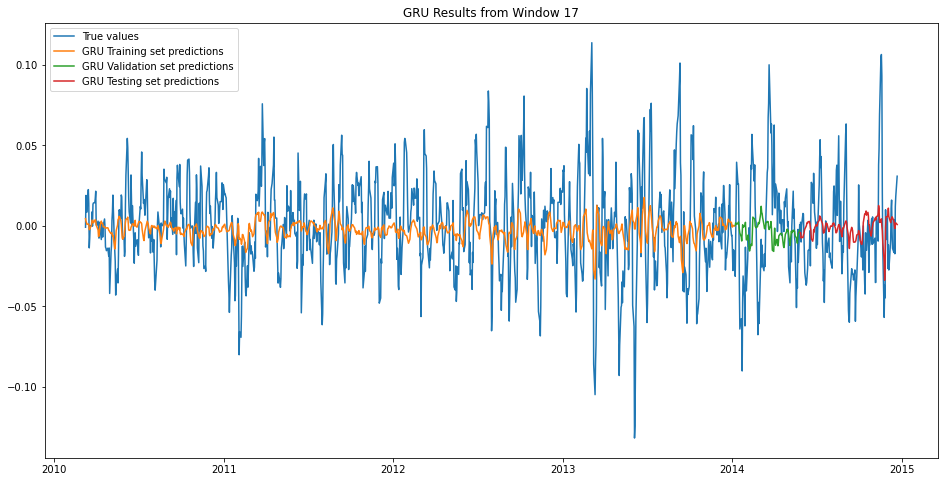

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.00041387577302029
RMSE = 0.020343937008855735
MAE = 0.015558483796801036
R-Squared = 0.5532249363746239

Results on Validation set: 
MSE = 0.0009761258712392322
RMSE = 0.03124301315877251
MAE = 0.020710102721939738
R-Squared = 0.08083579577044742

Results on Testing set: 
MSE = 0.0014328155877222756
RMSE = 0.03785255061052393
MAE = 0.029981936223261764
R-Squared = -0.44348071704553504



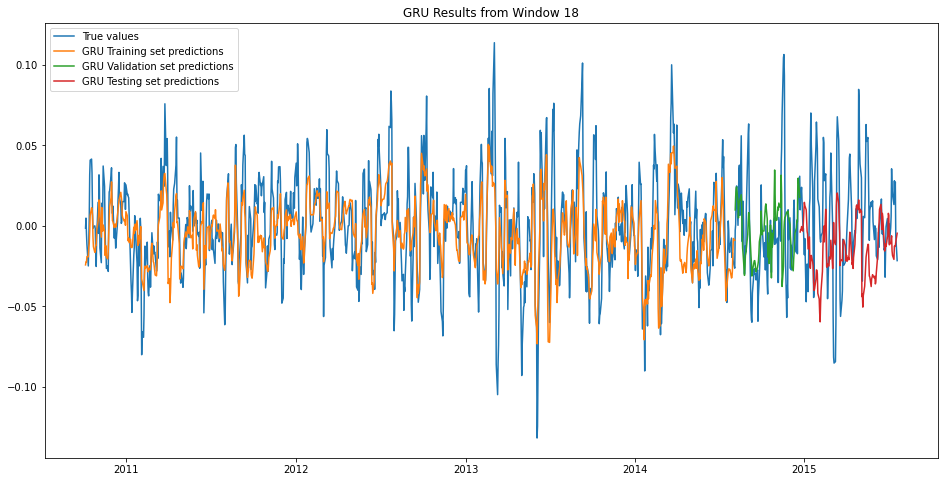

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0008803809822700902
RMSE = 0.029671214708368282
MAE = 0.02280272821975138
R-Squared = 0.09988269204019762

Results on Validation set: 
MSE = 0.0007831078853560155
RMSE = 0.027984064846909133
MAE = 0.02089206755835663
R-Squared = 0.21838532233697916

Results on Testing set: 
MSE = 0.0010902101349088845
RMSE = 0.03301833028650729
MAE = 0.026096083600674592
R-Squared = 0.029856710654269647



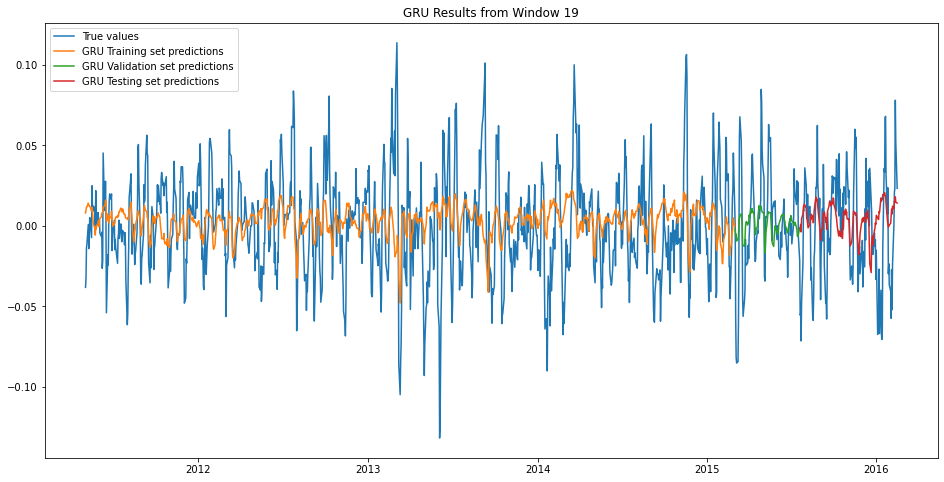

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0009794461329801734
RMSE = 0.031296104118247264
MAE = 0.024270448878713043
R-Squared = 0.07495222754181474

Results on Validation set: 
MSE = 0.0011189771877191785
RMSE = 0.03345111638972874
MAE = 0.026047511391839494
R-Squared = 0.046110704873144504

Results on Testing set: 
MSE = 0.0008813341587992157
RMSE = 0.029687272673642753
MAE = 0.02241222387877259
R-Squared = -0.2567871512763542



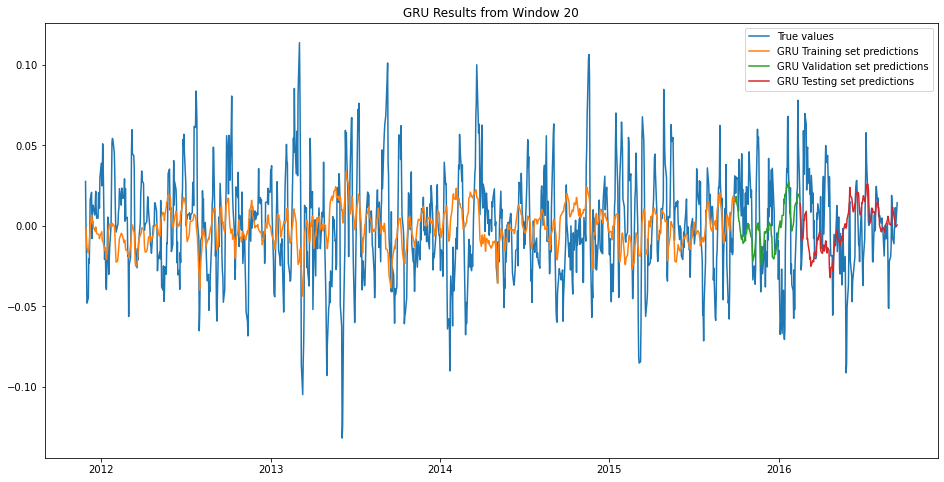

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0010242354040880053
RMSE = 0.032003677977507604
MAE = 0.024801013403965382
R-Squared = 0.09344570961247767

Results on Validation set: 
MSE = 0.0006440476968307661
RMSE = 0.025378094822716028
MAE = 0.018330915711829033
R-Squared = -0.11176732870609496

Results on Testing set: 
MSE = 0.0006694694877135884
RMSE = 0.025874108442873706
MAE = 0.02109475674646412
R-Squared = -0.0937391631652047



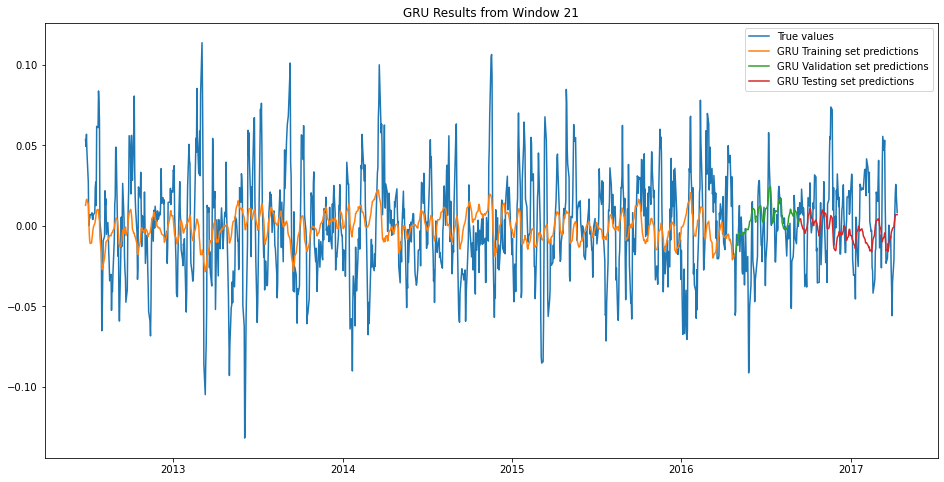

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0010120050277766747
RMSE = 0.03181202646447841
MAE = 0.02445534688672149
R-Squared = 0.07293467673634746

Results on Validation set: 
MSE = 0.0007000504549101885
RMSE = 0.026458466601641684
MAE = 0.02191485588219371
R-Squared = -0.23665701471164002

Results on Testing set: 
MSE = 0.0005359792499134297
RMSE = 0.023151225667627832
MAE = 0.01911410119760631
R-Squared = -0.01819263488643519



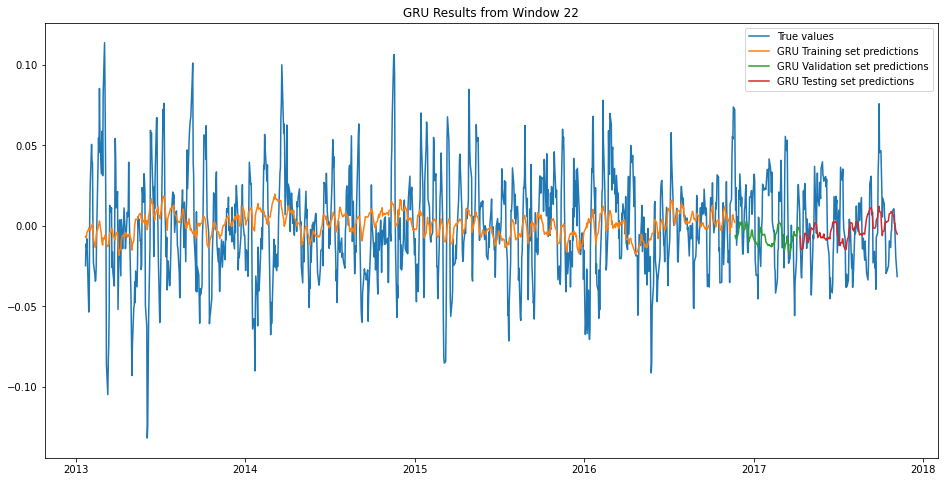

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0008438548482310683
RMSE = 0.029049179820281816
MAE = 0.02276855754874595
R-Squared = 0.07159160984208301

Results on Validation set: 
MSE = 0.0004286291352905368
RMSE = 0.020703360483036004
MAE = 0.017200324426988964
R-Squared = 0.13473811193465812

Results on Testing set: 
MSE = 0.0008131681608838876
RMSE = 0.02851610353614055
MAE = 0.022507625068813722
R-Squared = -0.003536205789116842



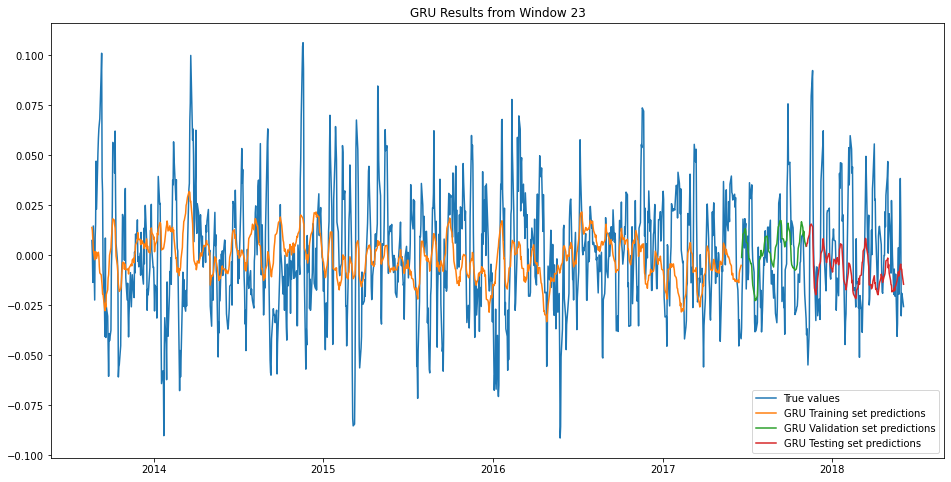

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0006976421957466993
RMSE = 0.026412917213869038
MAE = 0.021374476128393098
R-Squared = 0.16796656272233934

Results on Validation set: 
MSE = 0.0005842052528758302
RMSE = 0.024170338286334143
MAE = 0.019375009044973482
R-Squared = 0.16675462814464825

Results on Testing set: 
MSE = 0.0011644502150523995
RMSE = 0.03412404159903102
MAE = 0.026352174003505976
R-Squared = 0.06640314325570562



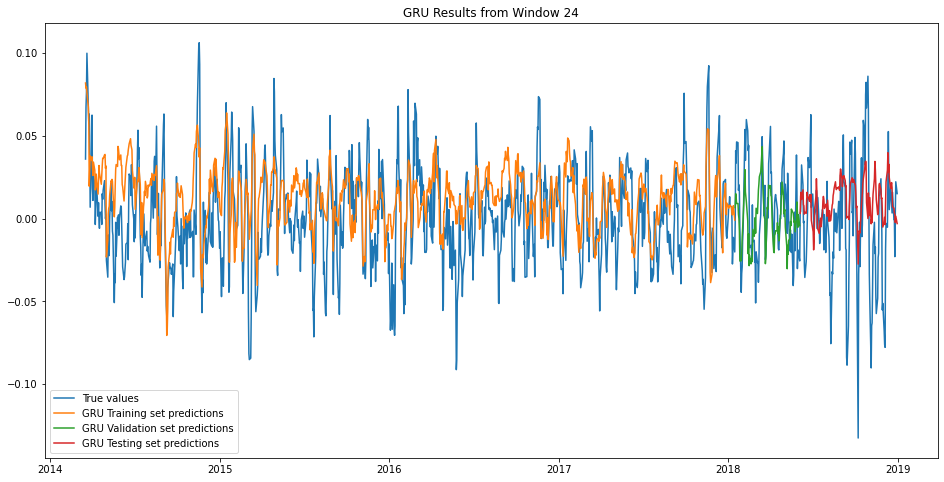

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4955

Results on Training set: 
MSE = 0.0008248979721585683
RMSE = 0.02872103710102698
MAE = 0.022516526391651616
R-Squared = -0.019284904405005632

Results on Validation set: 
MSE = 0.001406738218562287
RMSE = 0.03750650901593332
MAE = 0.02724620521768275
R-Squared = 0.10707000809538936

Results on Testing set: 
MSE = 0.0015478095743130808
RMSE = 0.03934221110096738
MAE = 0.03180345463202984
R-Squared = -0.06519476516537326



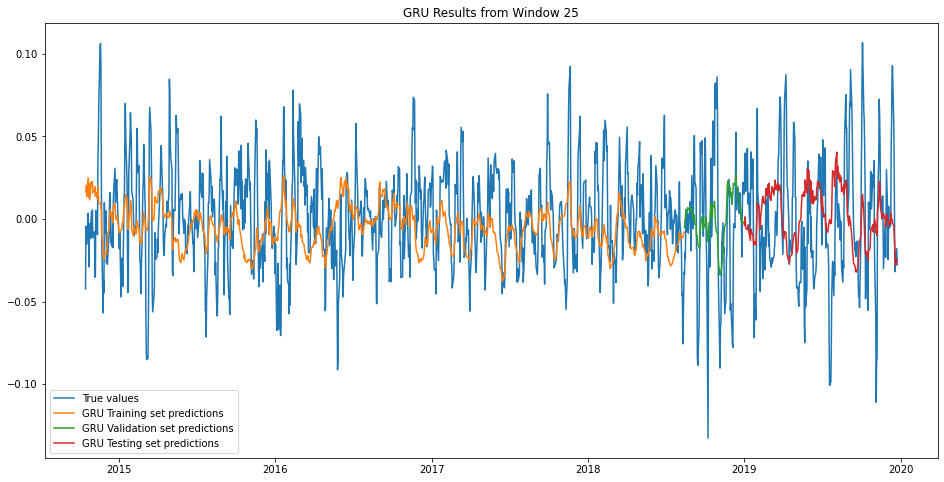

In [10]:
#Declaring model parameters
sequencelength = 163
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.001363978518147252
RMSE = 0.036932079797206814
MAE = 0.027697871680610737
R-Squared = -0.0954165077540663

GRU model results on the Testing set
MSE = 0.001459543275905794
RMSE = 0.038203969373689355
MAE = 0.029088424249842156
R-Squared = -0.17518531488752842

Naive model results on the Testing set
MSE = 0.00278664676919488
RMSE = 0.05278869925651588
MAE = 0.03923060637412652
R-Squared = -1.249804063141589

Drift model results on the Testing set
MSE = 0.003396407168191703
RMSE = 0.058278702526666656
MAE = 0.04291441519465157
R-Squared = -1.7420951702783012



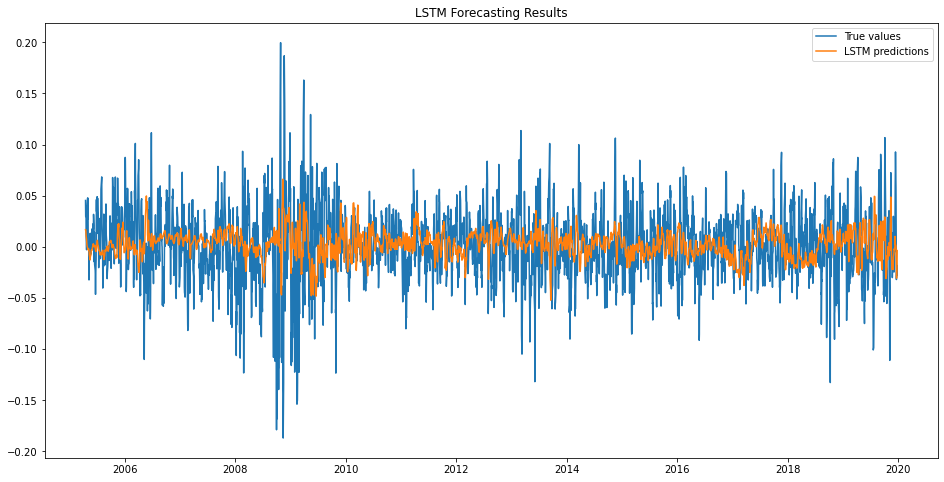

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

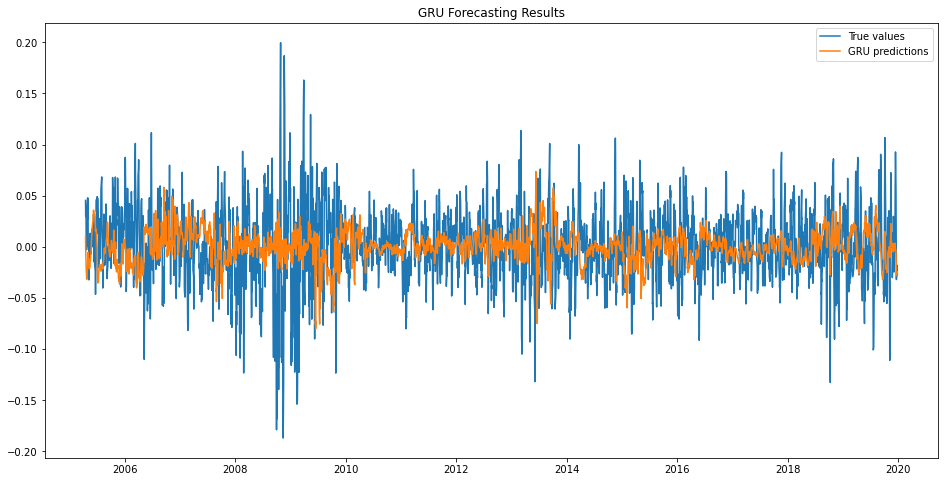

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

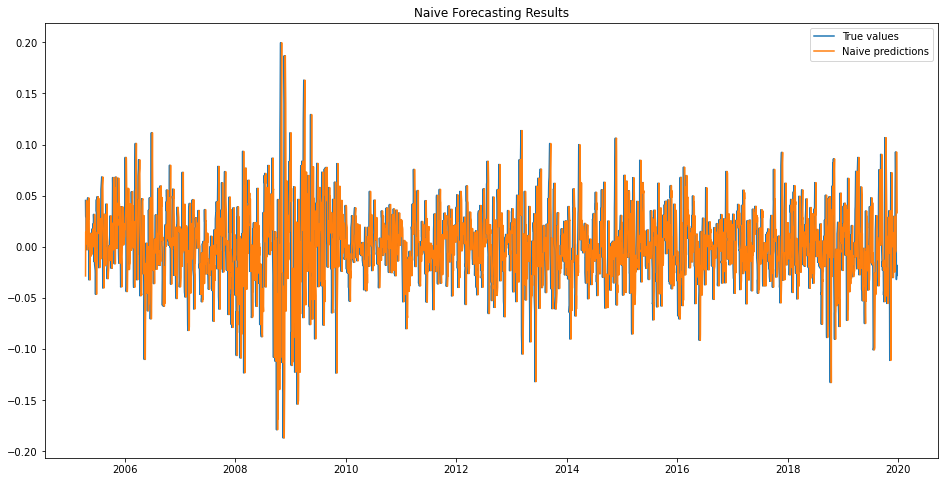

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

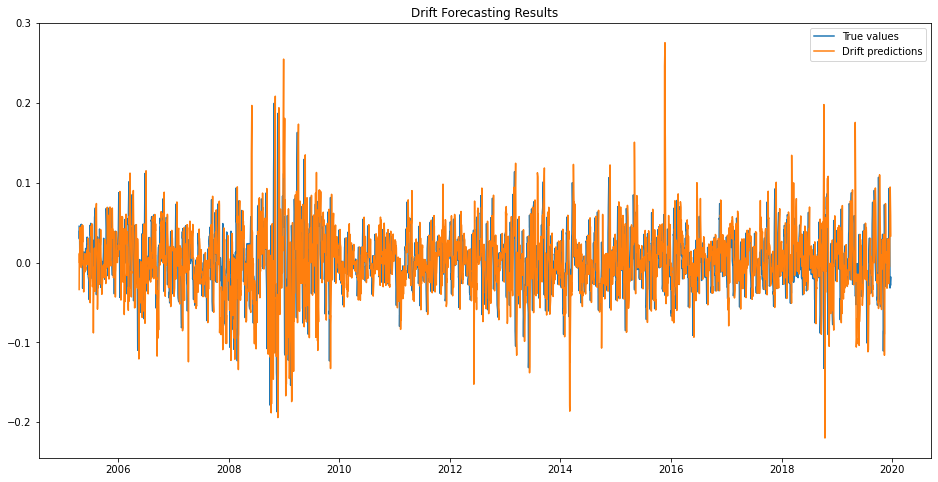

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['RLO LSTM'] = lstm_predictions[-numpreds:]
savePredictions['RLO GRU'] = gru_predictions[-numpreds:]
savePredictions['RLO Naive'] = naive_predictions[-numpreds:]
savePredictions['RLO Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./RLO_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

RLO LSTM   RLO GRU  RLO Naive  RLO Drift
Date                                                
2005-04-18  0.016867  0.010367  -0.028399  -0.033857
2005-04-19  0.016888 -0.003541   0.014472   0.011512
2005-04-20  0.015551 -0.010381   0.014181   0.011238
2005-04-21  0.013066 -0.011856   0.002911  -0.000625
2005-04-22  0.010491 -0.020146   0.017242   0.014532